# 2
* Extracción de columnas NaN y la preparación de data para hacer Complete Case Analysis
* Data Imputation categorícas y continuas
* Codificacion de variables categoricas
* Identificacion y tratamiento de Outliers (Aqui se encuentra la tarea 2)
* Transformación de Variables (cambio de escala)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler

In [ ]:
dataset = dataHP.copy()
(dataset == np.inf).sum().sort_values().tail(10)
def getColumnTypes (dataset):
    '''
    Categoriza las columnas de la dataset en continuas, discretas y categoricas. 
    Output: 3 listas con las columnas categorizadas. 
    '''
    continuas = []
    categoricas = []
    discretas = []
    for col in dataset.columns:
        if col.lower() == 'id':
            continue
        if dataset[col].dtype == 'int64' or dataset[col].dtype == 'float64':
            if dataset[col].nunique() > 30: # si la cantidad distintivos es mayor a 30, se asume que es una variable continua
                continuas.append(col)
            else:
                discretas.append(col)
        else:
            categoricas.append(col)

    return continuas, discretas, categoricas


def plotDensityQQ (dataset, col):
    '''
    Grafica la distribucion y el QQ-Plot de las columnas col de la pandas df dataset
    '''
    plt.figure(figsize=(15,6))
    plt.subplot(1,2,1)
    dataset[col].hist(bins=30)
    plt.title(f'Histograma - {col}')
    plt.subplot(1,2,2)
    stats.probplot(dataset[col], dist='norm', plot=plt)
    plt.title(f'QQ-Plot - {col}')
    plt.show()

def VariableTransformer(dataset, cols):
    '''
    Transforma las variables cols del pandas df dataset para maximizar la normalidad.
    Consideaciones:
        - El algoritmo no garantiza normalidad en todos los casos, solo la aproxima.
        - Solo se aplican 4 transformaciones ditintas: Inversa, cuadratica, boxcox y YeoJhonson
        - Solo aplica una transformacion por variable
    Output: 
        - el dataset transfromado
        - resumen de las transfromaciones realizadas
    '''  
    transformation_summary = pd.DataFrame(columns=['Variable', 'Normalidad', 'Transformada', 'Método'])

    for col in cols:
        shapiro_test = stats.shapiro(dataset[col])[1]
        if shapiro_test <= 0.05: # si p es menor a alpha, se rechaza Ho (Ho = la data es normal)
            tag = False
            p_values = [] # Almacenamos los valores p para cada transformación
            transformations = [] # Almacenamos las columnas transformadas
            methods = [ 'Cuadratica','Inversa', 'Boxcox', 'YeoJohnson']
            


            # Método 2 - cuadratica
            transformed = dataset[col]**2
            _, p = stats.shapiro(transformed)
            p_values.append(p)
            transformations.append(transformed)


            if (dataset[col] == 0).sum() < 1:
                # Método 1 - inversa
                transformed = 1 / dataset[col]
                _, p = stats.shapiro(transformed)
                p_values.append(p)
                transformations.append(transformed)

                # Método 3 - boxcox
                transformed, _ = stats.boxcox(dataset[col] + 1e-6) # Evitamos valores de 0
                _, p = stats.shapiro(transformed)
                p_values.append(p)
                transformations.append(transformed)

                # Método 4 - yeojohnson
                transformed, _ = stats.yeojohnson(dataset[col] + 1e-6) # Evitamos valores de 0
                _, p = stats.shapiro(transformed)
                p_values.append(p)
                transformations.append(transformed)

            # Escogemos la transformación con el mayor valor p
            best_transformation_data = transformations[np.argmax(p_values)]
            best_transformation_name = methods[np.argmax(p_values)]
            dataset[col] = best_transformation_data
            

            # Hacemos prueba de normalidad nuevamente
            shapiro_test = stats.shapiro(dataset[col])[1]
            if stats.shapiro(dataset[col])[1] <= 0.05:
                tag = False
            else:
                tag = True
            
            # Armamos fila con data actualizada
            new_row = pd.Series([col, tag, True, best_transformation_name], index=transformation_summary.columns)

        else:
            tag = True
            new_row = pd.Series([col, tag, False, np.NaN], index=transformation_summary.columns)
        
        transformation_summary = transformation_summary.append(new_row, ignore_index=True)
    return dataset, transformation_summary




def fill_missing_cats(dataset, target_column):
    '''
    Se seleccionan todas las varialbes categoricas para tratar los valores nulos respecto a la variable respuesta. 
    Si los valores nulos tienen una distribucion diferente a las demas categorias, los nulos se vuelven una categoria mas.
    De lo contrario, los valores nulos se sustituyen por la categoria con la distribucion mas parecida.
    Se utiliza una prueba T student con difernecia de medias suponiendo varianzas iguales entre los nulos y las demas categorias.
    Output: database con los nulos tratados   
    '''
    # Iteramos sobre todas las columnas del dataset
    for col in dataset.columns:
        # Si la columna es categórica
        if dataset[col].dtype == 'object':
            # Si hay nulos en la columna
            if dataset[col].isnull().any():
                # Guardamos los valores de la variable dependiente para los nulos
                null_values = dataset[dataset[col].isnull()][target_column]

                # Calculamos el p-valor de la prueba t para cada categoría
                p_values = {category: stats.ttest_ind(null_values, dataset[dataset[col] == category][target_column], equal_var=False, nan_policy='omit').pvalue for category in dataset[col].unique() if category is not np.nan}

                # Si todos los p-valores son menores que 0.05, sustituimos los nulos con 'Missing'
                if all(p < 0.05 for p in p_values.values()):
                    dataset[col].fillna('Missing', inplace=True)
                else:
                    # Si no, sustituimos los nulos con la categoría más similar (el mayor p-valor)
                    similar_category = max(p_values, key=p_values.get)
                    dataset[col].fillna(similar_category, inplace=True)

    return dataset



def outlierLimits (df, col):
    '''
    Calcula los limites inferiores y superiores en base al criterio de IQR
    df: pandas dataframe
    col: pandas dataframe column
    '''
    IQR = dataset[col].quantile(0.75) - dataset[col].quantile(0.25)
    LI =  dataset[col].quantile(0.25) - (IQR*1.75)
    LS =  dataset[col].quantile(0.75) + (IQR*1.75)
    return LI, LS
    

In [2]:
dataHP = pd.read_csv("../data/dataset_proyecto_statistical_learning.csv")
dataset = dataHP.copy()


In [3]:
(dataset == np.inf).sum().sort_values().tail(10)

creative          0
device            0
agerange          0
gender            0
weekstartdate     0
attribute         0
targetid          0
phone             0
unique_answers    0
age               0
dtype: int64

In [4]:
def getColumnTypes (dataset):
    '''
    Categoriza las columnas de la dataset en continuas, discretas y categoricas. 
    Output: 3 listas con las columnas categorizadas. 
    '''
    continuas = []
    categoricas = []
    discretas = []
    for col in dataset.columns:
        if col.lower() == 'id':
            continue
        if dataset[col].dtype == 'int64' or dataset[col].dtype == 'float64':
            if dataset[col].nunique() > 30: # si la cantidad distintivos es mayor a 30, se asume que es una variable continua
                continuas.append(col)
            else:
                discretas.append(col)
        else:
            categoricas.append(col)

    return continuas, discretas, categoricas


def plotDensityQQ (dataset, col):
    '''
    Grafica la distribucion y el QQ-Plot de las columnas col de la pandas df dataset
    '''
    plt.figure(figsize=(15,6))
    plt.subplot(1,2,1)
    dataset[col].hist(bins=30)
    plt.title(f'Histograma - {col}')
    plt.subplot(1,2,2)
    stats.probplot(dataset[col], dist='norm', plot=plt)
    plt.title(f'QQ-Plot - {col}')
    plt.show()

def VariableTransformer(dataset, cols):
    '''
    Transforma las variables cols del pandas df dataset para maximizar la normalidad.
    Consideaciones:
        - El algoritmo no garantiza normalidad en todos los casos, solo la aproxima.
        - Solo se aplican 4 transformaciones ditintas: Inversa, cuadratica, boxcox y YeoJhonson
        - Solo aplica una transformacion por variable
    Output: 
        - el dataset transfromado
        - resumen de las transfromaciones realizadas
    '''  
    transformation_summary = pd.DataFrame(columns=['Variable', 'Normalidad', 'Transformada', 'Método'])

    for col in cols:
        shapiro_test = stats.shapiro(dataset[col])[1]
        if shapiro_test <= 0.05: # si p es menor a alpha, se rechaza Ho (Ho = la data es normal)
            tag = False
            p_values = [] # Almacenamos los valores p para cada transformación
            transformations = [] # Almacenamos las columnas transformadas
            methods = [ 'Cuadratica','Inversa', 'Boxcox', 'YeoJohnson']
            


            # Método 2 - cuadratica
            transformed = dataset[col]**2
            _, p = stats.shapiro(transformed)
            p_values.append(p)
            transformations.append(transformed)


            if (dataset[col] == 0).sum() < 1:
                # Método 1 - inversa
                transformed = 1 / dataset[col]
                _, p = stats.shapiro(transformed)
                p_values.append(p)
                transformations.append(transformed)

                # Método 3 - boxcox
                transformed, _ = stats.boxcox(dataset[col] + 1e-6) # Evitamos valores de 0
                _, p = stats.shapiro(transformed)
                p_values.append(p)
                transformations.append(transformed)

                # Método 4 - yeojohnson
                transformed, _ = stats.yeojohnson(dataset[col] + 1e-6) # Evitamos valores de 0
                _, p = stats.shapiro(transformed)
                p_values.append(p)
                transformations.append(transformed)

            # Escogemos la transformación con el mayor valor p
            best_transformation_data = transformations[np.argmax(p_values)]
            best_transformation_name = methods[np.argmax(p_values)]
            dataset[col] = best_transformation_data
            

            # Hacemos prueba de normalidad nuevamente
            shapiro_test = stats.shapiro(dataset[col])[1]
            if stats.shapiro(dataset[col])[1] <= 0.05:
                tag = False
            else:
                tag = True
            
            # Armamos fila con data actualizada
            new_row = pd.Series([col, tag, True, best_transformation_name], index=transformation_summary.columns)

        else:
            tag = True
            new_row = pd.Series([col, tag, False, np.NaN], index=transformation_summary.columns)
        
        transformation_summary = transformation_summary.append(new_row, ignore_index=True)
    return dataset, transformation_summary




def fill_missing_cats(dataset, target_column):
    '''
    Se seleccionan todas las varialbes categoricas para tratar los valores nulos respecto a la variable respuesta. 
    Si los valores nulos tienen una distribucion diferente a las demas categorias, los nulos se vuelven una categoria mas.
    De lo contrario, los valores nulos se sustituyen por la categoria con la distribucion mas parecida.
    Se utiliza una prueba T student con difernecia de medias suponiendo varianzas iguales entre los nulos y las demas categorias.
    Output: database con los nulos tratados   
    '''
    # Iteramos sobre todas las columnas del dataset
    for col in dataset.columns:
        # Si la columna es categórica
        if dataset[col].dtype == 'object':
            # Si hay nulos en la columna
            if dataset[col].isnull().any():
                # Guardamos los valores de la variable dependiente para los nulos
                null_values = dataset[dataset[col].isnull()][target_column]

                # Calculamos el p-valor de la prueba t para cada categoría
                p_values = {category: stats.ttest_ind(null_values, dataset[dataset[col] == category][target_column], equal_var=False, nan_policy='omit').pvalue for category in dataset[col].unique() if category is not np.nan}

                # Si todos los p-valores son menores que 0.05, sustituimos los nulos con 'Missing'
                if all(p < 0.05 for p in p_values.values()):
                    dataset[col].fillna('Missing', inplace=True)
                else:
                    # Si no, sustituimos los nulos con la categoría más similar (el mayor p-valor)
                    similar_category = max(p_values, key=p_values.get)
                    dataset[col].fillna(similar_category, inplace=True)

    return dataset



def outlierLimits (df, col):
    '''
    Calcula los limites inferiores y superiores en base al criterio de IQR
    df: pandas dataframe
    col: pandas dataframe column
    '''
    IQR = dataset[col].quantile(0.75) - dataset[col].quantile(0.25)
    LI =  dataset[col].quantile(0.25) - (IQR*1.75)
    LS =  dataset[col].quantile(0.75) + (IQR*1.75)
    return LI, LS

In [5]:
continuas, discretas, categoricas = getColumnTypes(dataset) # se separan todas las columnas en base a su tipo
for i in [continuas, discretas, categoricas]:
    print(len(i))

6
9
17


## Tratamiento datos nulos

In [6]:
nan_proporcion =  dataset.isnull().mean()
nan_proporcion = nan_proporcion[lambda x: x>0]
nan_proporcion

phone          0.003256
gender         0.003256
agerange       0.002006
device         0.003256
creative       0.002006
placement      0.002006
deviceos       0.003256
property       0.002006
publisher      0.052134
state          0.003256
utmsource      0.009111
utmcampaign    0.389573
age            0.000691
dtype: float64

### Variables categoricas

In [7]:
fill_missing_cats(dataset, 'unique_leads')

c:\Users\DELL\anaconda3.7\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
c:\Users\DELL\anaconda3.7\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
c:\Users\DELL\anaconda3.7\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
c:\Users\DELL\anaconda3.7\lib\site-packages\numpy\core\fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
c:\Users\DELL\anaconda3.7\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,date,phone,targetid,attribute,weekstartdate,gender,agerange,device,creative,placement,...,property,publisher,campaignname,state,utmsource,utmcampaign,campaigntype,unique_leads,unique_answers,age
0,2023-07-01,2.055080e+09,645cdca06beec953cd8ceef8,Health (cancer),2023-07-01,FEMALE,30 - 39,MOBILE,8984142e-3a16-4599-8f0a-41f897cf2d52,GetItFree - All Traffic - Primary,...,GetItFree,Tibrio,QVS - Mass Tort Talcum - Day,AL,1b09a870785a7b4419ac7e90508c12fc,35c07a2d9a9290106b73bed7bd207e80,Talcum,0,0,31.0
1,2023-07-01,4.142028e+09,645cdca06beec953cd8cef14,Health (cancer: Stage I),2023-07-01,FEMALE,50 - 59,MOBILE,8984142e-3a16-4599-8f0a-41f897cf2d52,Workn Well - Primary Placement,...,Workn Well,Tibrio,QVS - Mass Tort Talcum - Day,WI,d7aefe10a495029cf52085a85426b415,31e18e575a569774b0060e67f86e9fdb,Talcum,0,0,53.0
2,2023-07-01,4.013788e+09,645cdeab6beec953cd8cef94,Health (cancer: Stage Iv),2023-07-01,FEMALE,60 - 69,MOBILE,33253883-03db-421c-874f-2acb78459fb3,Workn Well - Primary Placement,...,Workn Well,Tibrio,QVS - Mass Tort Talcum - AH,MA,d7aefe10a495029cf52085a85426b415,31e18e575a569774b0060e67f86e9fdb,Talcum,0,0,61.0
3,2023-07-01,9.312543e+09,645cdeaa6beec953cd8cef84,Health (cancer: Stage Ii),2023-07-01,FEMALE,50 - 59,MOBILE,33253883-03db-421c-874f-2acb78459fb3,Workn Well - Primary Placement,...,Workn Well,Tibrio,QVS - Mass Tort Talcum - AH,TN,4fa2c5c1c8766abe797da7106c0801b8,ecc7c7a42da7ea88566499d1dc280a7f,Talcum,0,0,59.0
4,2023-07-01,9.312739e+09,645cdeab6beec953cd8cef92,Health (cancer: Stage Iii),2023-07-01,FEMALE,60 - 69,MOBILE,33253883-03db-421c-874f-2acb78459fb3,Workn Well - Primary Placement,...,Workn Well,Tibrio,QVS - Mass Tort Talcum - AH,TN,4fa2c5c1c8766abe797da7106c0801b8,ecc7c7a42da7ea88566499d1dc280a7f,Talcum,0,0,68.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60800,2023-02-07,7.734317e+09,63e2ef3ed1414a450236cfa4,Health (cancer),2023-02-07,FEMALE,30 - 39,MOBILE,b0a3b69c0521fbffc0aca84bec2adacf,PrizeStash - TXM - Primary,...,PrizeStash,"Digipropz, LLC",Mass tort round up AH - 63e23c700d7206acdb306e4d,IL,2e54aa0ab2b02a0dccdbfec72e1d0bcc,0,Talcum,0,0,36.0
60801,2023-02-07,6.015776e+09,63e2ef3ed1414a450236cfa4,Health (cancer),2023-02-07,FEMALE,20 - 29,MOBILE,b0a3b69c0521fbffc0aca84bec2adacf,PrizeStash - TXM - Primary,...,PrizeStash,"Digipropz, LLC",Mass tort round up AH - 63e23c700d7206acdb306e4d,MS,2e54aa0ab2b02a0dccdbfec72e1d0bcc,0,Talcum,0,0,29.0
60802,2023-02-07,9.315758e+09,63e2ef3ed1414a450236cf9a,Health (cancer: Stage Iv),2023-02-07,FEMALE,30 - 39,MOBILE,b0a3b69c0521fbffc0aca84bec2adacf,PrizeStash - TXM - Primary,...,PrizeStash,"Digipropz, LLC",Mass tort round up AH - 63e23c700d7206acdb306e4d,TN,20d7231ce28c2a0ce3d4e997632eac6e,0,Talcum,0,0,38.0
60803,2023-02-07,8.322925e+09,63e2ef3ed1414a450236cfa2,Health (cancer: Diagnosed),2023-02-07,FEMALE,50 - 59,MOBILE,4ae8788fd57fc376cbfbfd54e98a0c1e,Jetsetty - Primary Placement,...,Jetsetty,"Jetsetty, LLC",Mass tort round up AH - 63e23c700d7206acdb306e4d,TX,0c75fe01f9a578c108d058e6b1175909,d041f5c90c2e507ec900b536711379bc,Talcum,0,0,57.0


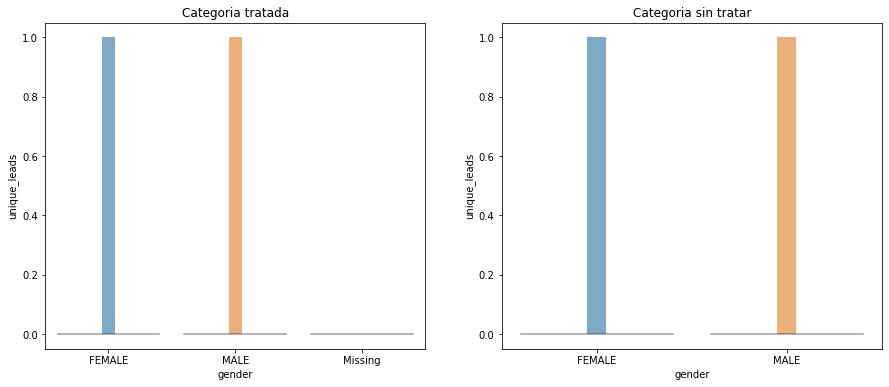

In [8]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
sns.boxenplot(x=dataset['gender'], y=dataHP['unique_leads'])
plt.title('Categoria tratada')

plt.subplot(1,2,2)
sns.boxenplot(x=dataHP['gender'], y=dataHP['unique_leads'])
plt.title(f'Categoria sin tratar')
plt.show()


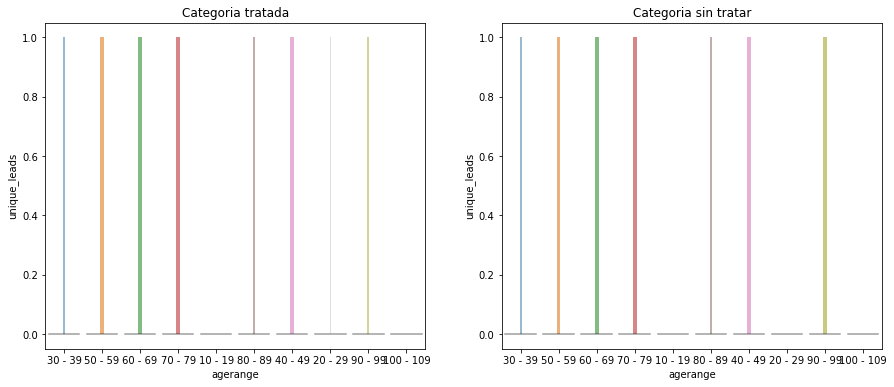

In [9]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
sns.boxenplot(x=dataset['agerange'], y=dataHP['unique_leads'])
plt.title('Categoria tratada')

plt.subplot(1,2,2)
sns.boxenplot(x=dataHP['agerange'], y=dataHP['unique_leads'])
plt.title(f'Categoria sin tratar')
plt.show()


### Imputacion media para variables restantes

In [10]:
nan_proporcion =  dataset.isnull().mean()
nan_proporcion = nan_proporcion[lambda x: x>0]
nan_proporcion
dataset = dataset.fillna(dataset.median())

### Identifiacion y tratamiento de Outliers

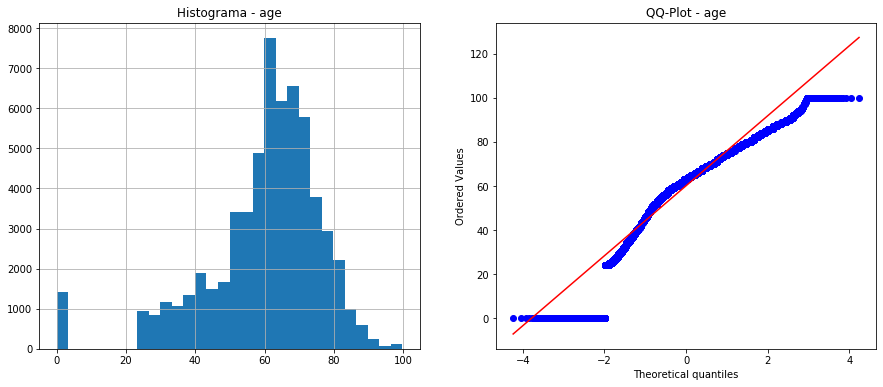

In [11]:
# tarea 2: automatizacion para que outliers sean = 0 en vez de negativos

for col in continuas: 
    LI, LS = outlierLimits(dataset, col)
    dataset[col] = np.where(dataset[col] > LS, LS, np.where(dataset[col] < LI, 0, dataset[col] )) # Se sustituye todo lo que esta fuera de limites al valor de los limites

plotDensityQQ(dataset, col)

## Codificacion de variables categoricas

In [12]:
for cat in categoricas:
    temp_freqs = dataset[cat].value_counts(normalize=True).to_dict()
    dataset[f'{cat}_code'] = dataset[cat].map(temp_freqs)
dataset[['agerange', 'agerange_code']]


,agerange,agerange_code
0,30 - 39,0.059091
1,50 - 59,0.192698
2,60 - 69,0.336403
3,50 - 59,0.192698
4,60 - 69,0.336403
...,...,...
60800,30 - 39,0.059091
60801,20 - 29,0.050571
60802,30 - 39,0.059091
60803,50 - 59,0.192698


## Transformacion de variables, Normalizacion y Escalamiento

c:\Users\DELL\anaconda3.7\lib\site-packages\scipy\stats\morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
c:\Users\DELL\anaconda3.7\lib\site-packages\scipy\stats\morestats.py:1478: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(trans.var(axis=0))
c:\Users\DELL\anaconda3.7\lib\site-packages\scipy\optimize\optimize.py:1984: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
c:\Users\DELL\anaconda3.7\lib\site-packages\scipy\optimize\optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
c:\Users\DELL\anaconda3.7\lib\site-packages\scipy\optimize\optimize.py:1986: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
c:\Users\DELL\anaconda3.7\lib\site-packages\scipy\optimize\optimize.py:1987: RuntimeWarning: invalid value encountered in 

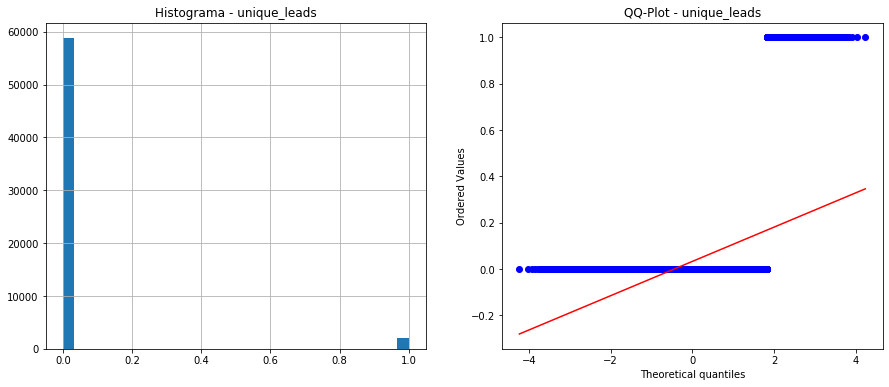

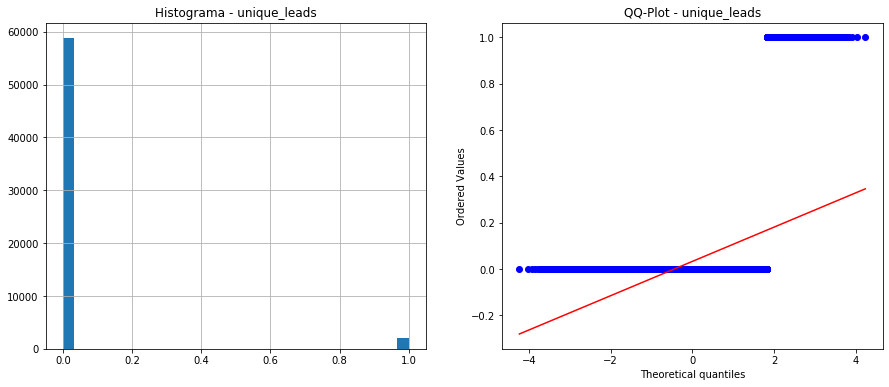

In [13]:
dataset_final, summary = VariableTransformer(dataset, continuas)
plotDensityQQ(dataHP, 'unique_leads')
plotDensityQQ(dataset_final, 'unique_leads')

In [14]:
VariableTransformer(dataset, continuas)

c:\Users\DELL\anaconda3.7\lib\site-packages\scipy\stats\morestats.py:1673: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
c:\Users\DELL\anaconda3.7\lib\site-packages\scipy\stats\morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(             date     phone                  targetid  \
 0      2023-07-01  0.501296  645cdca06beec953cd8ceef8   
 1      2023-07-01  0.501296  645cdca06beec953cd8cef14   
 2      2023-07-01  0.501296  645cdeab6beec953cd8cef94   
 3      2023-07-01  0.501296  645cdeaa6beec953cd8cef84   
 4      2023-07-01  0.501296  645cdeab6beec953cd8cef92   
 ...           ...       ...                       ...   
 60800  2023-02-07  0.501296  63e2ef3ed1414a450236cfa4   
 60801  2023-02-07  0.501296  63e2ef3ed1414a450236cfa4   
 60802  2023-02-07  0.501296  63e2ef3ed1414a450236cf9a   
 60803  2023-02-07  0.501296  63e2ef3ed1414a450236cfa2   
 60804  2023-02-07  0.501296  63e2ef3ed1414a450236cf96   
 
                         attribute weekstartdate  gender agerange  device  \
 0                 Health (cancer)    2023-07-01  FEMALE  30 - 39  MOBILE   
 1        Health (cancer: Stage I)    2023-07-01  FEMALE  50 - 59  MOBILE   
 2       Health (cancer: Stage Iv)    2023-07-01  FEMALE  60 - 69  MOBI

In [15]:
stats.shapiro(dataset["age"])[1]

c:\Users\DELL\anaconda3.7\lib\site-packages\scipy\stats\morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


0.0

In [16]:
dataset.mean()

phone                 5.012964e-01
records               1.000000e+00
calls                 6.763682e+06
contacts              1.630557e+00
humananswers          1.264386e+00
voicemail             3.666021e+06
answered              5.443467e-01
leads                 4.045720e-02
billable              1.050900e-02
revenue               2.678398e+00
marketingcost         8.536465e-02
totalcost             2.418056e-01
unique_leads          3.318806e-02
unique_answers        5.443467e-01
age                   1.804282e+07
date_code             1.311876e-02
targetid_code         1.197221e-02
attribute_code        2.273025e-01
weekstartdate_code    1.311876e-02
gender_code           4.969482e-01
agerange_code         2.094997e-01
device_code           8.553278e-01
creative_code         5.376209e-02
placement_code        1.802261e-01
deviceos_code         5.735089e-01
property_code         1.802261e-01
publisher_code        3.950293e-01
campaignname_code     1.315874e-01
state_code          

In [23]:
scaler = StandardScaler()
scaler.fit(dataset_final[continuas]) # se extrae info interna (parametros) para transformaciones posteriores. En este caso son la media y la std
dataHP_scaled = scaler.transform(dataset_final[continuas])
dataHP_scaled = pd.DataFrame(dataHP_scaled, columns=continuas)


In [27]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

continuas = ['phone', 'calls', 'voicemail', 'marketingcost', 'totalcost', 'age']  
scaler = StandardScaler()
scaler.fit(dataset_final[continuas]) 
dataHP_scaled = scaler.transform(dataset_final[continuas])
dataHP_scaled_df = pd.DataFrame(dataHP_scaled, columns=continuas)
dataset_final_dropped = dataset_final.drop(columns=continuas)
dataset_final_scaled = pd.concat([dataset_final_dropped, dataHP_scaled_df], axis=1)


In [28]:
dataset_final_scaled.to_csv("../data/dataset_proyecto_statistical_learning_scaled.csv")
dataset_final_scaled

,date,targetid,attribute,weekstartdate,gender,agerange,device,creative,placement,deviceos,...,state_code,utmsource_code,utmcampaign_code,campaigntype_code,phone,calls,voicemail,marketingcost,totalcost,age
0,2023-07-01,645cdca06beec953cd8ceef8,Health (cancer),2023-07-01,FEMALE,30 - 39,MOBILE,8984142e-3a16-4599-8f0a-41f897cf2d52,GetItFree - All Traffic - Primary,Android,...,0.024685,0.021840,0.045753,0.454749,0.0,-0.383248,-0.358253,-0.282725,-0.414268,-1.244280
1,2023-07-01,645cdca06beec953cd8cef14,Health (cancer: Stage I),2023-07-01,FEMALE,50 - 59,MOBILE,8984142e-3a16-4599-8f0a-41f897cf2d52,Workn Well - Primary Placement,Android,...,0.009572,0.001579,0.001480,0.454749,0.0,-0.383248,-0.358253,-0.282725,-0.414268,-0.737901
2,2023-07-01,645cdeab6beec953cd8cef94,Health (cancer: Stage Iv),2023-07-01,FEMALE,60 - 69,MOBILE,33253883-03db-421c-874f-2acb78459fb3,Workn Well - Primary Placement,Android,...,0.011002,0.001579,0.001480,0.454749,0.0,-0.383248,-0.358253,-0.282725,-0.414268,-0.305049
3,2023-07-01,645cdeaa6beec953cd8cef84,Health (cancer: Stage Ii),2023-07-01,FEMALE,50 - 59,MOBILE,33253883-03db-421c-874f-2acb78459fb3,Workn Well - Primary Placement,Android,...,0.024965,0.181827,0.280388,0.454749,0.0,-0.383248,-0.358253,-0.282725,-0.414268,-0.430679
4,2023-07-01,645cdeab6beec953cd8cef92,Health (cancer: Stage Iii),2023-07-01,FEMALE,60 - 69,MOBILE,33253883-03db-421c-874f-2acb78459fb3,Workn Well - Primary Placement,Android,...,0.024965,0.181827,0.280388,0.454749,0.0,-0.383248,-0.358253,-0.282725,-0.414268,0.242656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60800,2023-02-07,63e2ef3ed1414a450236cfa4,Health (cancer),2023-02-07,FEMALE,30 - 39,MOBILE,b0a3b69c0521fbffc0aca84bec2adacf,PrizeStash - TXM - Primary,Android,...,0.032349,0.198438,0.069484,0.454749,0.0,-0.383248,-0.358253,-0.581051,-0.504320,-1.189325
60801,2023-02-07,63e2ef3ed1414a450236cfa4,Health (cancer),2023-02-07,FEMALE,20 - 29,MOBILE,b0a3b69c0521fbffc0aca84bec2adacf,PrizeStash - TXM - Primary,Android,...,0.015377,0.198438,0.069484,0.454749,0.0,-0.383248,-0.358253,-0.581051,-0.504320,-1.259997
60802,2023-02-07,63e2ef3ed1414a450236cf9a,Health (cancer: Stage Iv),2023-02-07,FEMALE,30 - 39,MOBILE,b0a3b69c0521fbffc0aca84bec2adacf,PrizeStash - TXM - Primary,Android,...,0.024965,0.125450,0.069484,0.454749,0.0,-0.383248,-0.358253,-0.581051,-0.504320,-1.159850
60803,2023-02-07,63e2ef3ed1414a450236cfa2,Health (cancer: Diagnosed),2023-02-07,FEMALE,50 - 59,MOBILE,4ae8788fd57fc376cbfbfd54e98a0c1e,Jetsetty - Primary Placement,Android,...,0.099811,0.027284,0.067018,0.454749,0.0,-0.383248,-0.358253,-0.581051,-0.504320,-0.544164
